In [1]:
import sys
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline

In [3]:
d, info = matlab.loaddata('../../mat/strategy_270225.mat')

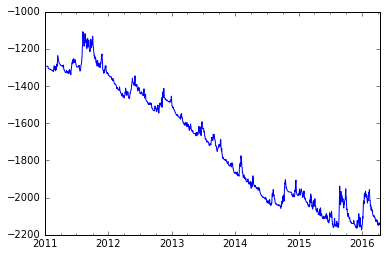

In [4]:
d.exo.plot();

In [5]:
info

{'legs': 4,
 'name': 'BearishCollarBrokenWing',
 'pcf': array([1, 2, 0, 1], dtype=uint8),
 'pcfqty': array([-1, -1,  1,  1], dtype=int16),
 'tickincrement': 0.25,
 'tickvalue': 12.5,
 'underlying': 'EP'}

# Naive swarming


In [20]:
def naive_swarm():
    for slowp in np.arange(40, 100, 5):
            for fastp in np.arange(5, 20, 2):
                slow_ma = d.exo.rolling(slowp).mean()
                fast_ma = d.exo.rolling(fastp).mean()

                short_entry = CrossDown(fast_ma, slow_ma)
                short_exit = CrossUp(fast_ma, slow_ma)

                direction = -1
                pl1, inposition1 = backtester.backtest(d, short_entry, short_exit, direction )
                equity1, stats1 = backtester.stats(pl1, inposition1)
                equity1.plot()


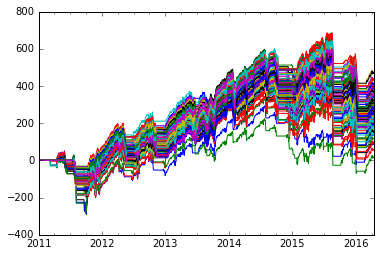

In [21]:
%prun naive_swarm()

# Cython optimized backtesting

In [6]:
%load_ext Cython

In [7]:
%%cython 
# --annotate

import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt
import pandas as pd

DTYPE = np.int
ctypedef np.double_t DTYPE_t_double
ctypedef np.int8_t DTYPE_t_int8

@cython.boundscheck(False) # turn of bounds-checking for entire function
def stats(profitloss, inposition):
    """
    Calculate equity and summary statistics, based on output of `backtest` method
    :param pl: Profit-loss array (returned by backtest())
    :param inposition: In-position array (returned by backtest())
    :return: tuple (equity, stats)
        - equity - is cumulative profits arrat
        - stats - is a dict()
    """    
    cdef int barcount = len(profitloss)
    cdef np.ndarray[np.double_t, ndim=1] equity = np.zeros(barcount, dtype=np.double)
    cdef np.ndarray[DTYPE_t_double, ndim=1] pl = profitloss.values
    cdef np.ndarray[DTYPE_t_int8, ndim=1] inpos = inposition.values
    cdef double profit = 0.0
    
    cdef double netprofit = 0.0
    cdef double tradeprofit = 0.0
    cdef double count = 0.0
    cdef double winscount = 0.0
    cdef double highesteqty = 0.0
    cdef double maxdd = 0.0
    cdef double p = 0.0
    cdef double cumulativep = 0.0
    # 
    
    # Calculate trade-by-trade payoffs        
    for i in range(barcount):
        if i == 0:
            continue
        # Calculate cumulative profit inside particular trade
        p = pl[i]
        if np.isnan(p):
            continue
        
        cumulativep += p
        if inpos[i] == 1:
            tradeprofit += p
        # Store result
        if inpos[i] == 0 and inpos[i-1] == 1:            
            count += 1.0
            if tradeprofit > 0:
                winscount += 1.0         
            netprofit += tradeprofit
            tradeprofit = 0.0
            
        highesteqty = max(highesteqty, cumulativep)   
        maxdd = min(maxdd, cumulativep - highesteqty)                
        equity[i] = cumulativep 
    

    # Calculate summary statistics
    statistics = {
        'netprofit': netprofit,
        'avg': netprofit / count,
        'count': count,
        'winrate': winscount / count,
        'maxdd': maxdd,
    }
    return pd.Series(equity, index=profitloss.index), statistics

In [9]:
def optimized_swarm():
    for slowp in np.arange(40, 100, 5):
            for fastp in np.arange(5, 20, 2):
                slow_ma = d.exo.rolling(slowp).mean()
                fast_ma = d.exo.rolling(fastp).mean()

                short_entry = CrossDown(fast_ma, slow_ma)
                short_exit = CrossUp(fast_ma, slow_ma)

                direction = -1
                # Calling Cython optimized methods
                pl2, inposition2 = backtest(d, short_entry, short_exit, direction )
                equity2, stats2 = stats(pl2, inposition2)


In [18]:
%prun optimized_swarm()

In [10]:
slow_ma = d.exo.rolling(50).mean()
fast_ma = d.exo.rolling(20).mean()
short_entry = CrossDown(fast_ma, slow_ma)
short_exit = CrossUp(fast_ma, slow_ma)
direction = -1

In [32]:
%%cython 
#--annotate

import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt
import pandas as pd

DTYPE = np.int

ctypedef np.double_t DTYPE_t_double

@cython.boundscheck(False) # turn of bounds-checking for entire function
def backtest(np.ndarray[np.double_t, ndim=1] price, 
             np.ndarray[np.uint8_t,cast=True, ndim=1] entry_rule, 
             np.ndarray[np.uint8_t,cast=True, ndim=1] exit_rule, 
             int direction,
             date):
    """
    Backtester routine calculate equity based on data['exo'] and entry/exit rules
    :param data: raw data for backtesting
    :param entry_rule: 1/0 array of entry points
    :param exit_rule: 1/0 array of exit points
    :param direction: Direction of trades, 1 - for long, -1 - for shorts
    :return: tuple(pl, inposition)
        pl - profit-loss inside a particular trade
        inposition - 1/0 array indicating whether the EXO is in or out of the market at the end of the day
    """    
    cdef int barcount = len(price)
    cdef np.ndarray[np.double_t, ndim=1] pl = np.zeros(barcount, dtype=np.double)
    cdef np.ndarray[np.int8_t,   ndim=1] inposition = np.zeros(barcount, dtype=np.int8)
    
    inpos = False

    for i in range(barcount):
        if not inpos:
            # We have a signal, let's open position
            if entry_rule[i] == 1:
                pl[i] = 0
                inpos = True
                inposition[i] = 1
            else:
                inposition[i] = 0

        else:
            # Calculate pl
            pl[i] = (price[i] - price[i-1])*direction
            inposition[i] = 1

            if exit_rule[i] == 1:
                inpos = False
                
    return pd.Series(pl, index=date),  pd.Series(inposition, index=date)

### Timing compare between naive python and cython optimized code

In [11]:
# Naive python timings
%timeit backtester.backtest(d, short_entry, short_exit, direction )

100 loops, best of 3: 10.7 ms per loop


In [31]:
# Cython optimized code
%timeit backtest(d.exo.values, short_entry.values, short_exit.values, direction, d.exo.index)


100 loops, best of 3: 3.83 ms per loop
